# Lecture 05  
### Introduction to Cython - Part 02
### February 25, 2020    

---

Based on the material https://nyu-cds.github.io/python-cython/

This lecture provides a very brief introduction to Cython. See the [Cython documentation](http://cython.readthedocs.io/en/latest/) for a more detailed description of the Cython language.

----
## Cython for NumPy Users
NumPy can be used from Cython in exactly the same manner as in regular Python, however Cython also has a number of features that support fast access to NumPy arrays that can result in significant performance gains.

### Convolution -- Example Image Convolution 



N^2/M^2 <br>
N is the big picture: f <br>
M is the small part of picutre filter: g (x,y) (len,width) <br>


Image processing uses convolution of an input image and corresponding kernel for blurring, sharpening, embossing, edge detection, etc. 

https://en.wikipedia.org/wiki/Kernel_(image_processing)


#### Convolution of two functions: $f \star g$

Discrete, on $\mathbf{Z}$: $$(f \star g) [n] = \sum_k f[k] g[n-k]$$

Continuous, on $\mathbf{R}$: $$(f \star g) (x) = \int f(t) g(x-t) d t $$

Continuous, on $\mathbf{R}^2$: $$(f \star g) (\vec{z}) = \int f(\vec{u}) g(\vec{z}-\vec{u}) d \vec{u}$$




In [1]:
# Pure python code
import numpy as np

def naive_convolve(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    # for every comb of i j, compute h which is defined by the filter
    # average around the ij pixels 
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
            # min() dont want the filter to go over the boundsry of the picutre
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

In [2]:
from matplotlib import pyplot as plt

I = np.random.uniform(low=0, high=1.0, size=((250, 250)))
G = np.ones((5, 5)) * (1/25)
print(I)
print(G)
%prun H = naive_convolve(I, G)

plt.subplot(1, 2, 1)
plt.imshow(I)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(H)
plt.axis('off')

plt.show()

[[0.69087915 0.060174   0.68454026 ... 0.82244054 0.51394398 0.49560381]
 [0.68006934 0.34841833 0.50460029 ... 0.61459921 0.08574202 0.4735524 ]
 [0.09907299 0.17327766 0.69262923 ... 0.78477175 0.45621525 0.08239558]
 ...
 [0.4961165  0.04762807 0.65107441 ... 0.11447064 0.91045545 0.79378917]
 [0.35101264 0.48403553 0.54636487 ... 0.09629236 0.22152118 0.12140769]
 [0.25617856 0.70498152 0.42258627 ... 0.99727508 0.46581045 0.945778  ]]
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]
 

<Figure size 640x480 with 2 Axes>

In [3]:
# 371255 function calls in 1.636 seconds

In [4]:
# using cython (the following code is identical to the previous on)
%load_ext Cython

In [5]:
%%cython

# Pure python code
import numpy as np

def naive_convolve_cython(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

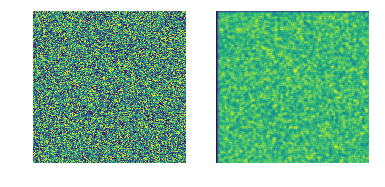

In [6]:
from matplotlib import pyplot as plt

Ic = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gc = np.ones((5, 5)) * (1/25)
%prun Hc = naive_convolve_cython(Ic, Gc)

plt.subplot(1, 2, 1)
plt.imshow(Ic)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hc)
plt.axis('off')

plt.show()

In [7]:
#  4 function calls in 1.233 seconds
# 20% faster than before

-We now add Cython data types to the code. The new code will no longer be compatible with Python.  

-Must be carefully considered. 

-The most important change is to use variables that have the same data type as the elements of the NumPy arrays.

In [8]:
# compiling with cython using ctypes
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [9]:
%%cython
import numpy as np
cimport numpy as np # need to import special compile-time information

def naive_convolve_cython_with_ctypes(np.ndarray f, np.ndarray g): # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    cdef np.ndarray h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

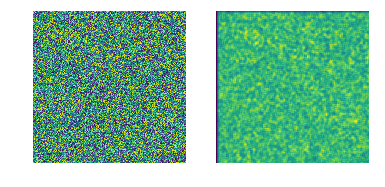

In [10]:
from matplotlib import pyplot as plt

Ict = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gct = np.ones((5, 5))* (1/25)
%prun Hct = naive_convolve_cython_with_ctypes(Ict,Gct)

plt.subplot(1, 2, 1)
plt.imshow(Ict)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hct)
plt.axis('off')

plt.show()

In [11]:
# 4 function calls in 1.197 seconds

### Efficient Indexing

- Still a bottleneck: the array lookups and assignments. 

- The []-operator still uses full Python operations;

- Instead access the data buffer directly (at the speed of C)

- Need to do is to type the contents of the ndarray objects; 

- We do this with a special “buffer” syntax which must be told:

- (i) the datatype (first argument), and 

- (ii) number of dimensions (“ndim” keyword-only argument, if not provided then one-dimensional is assumed).


In [12]:
# compiling with cython typing the content of ndarray objects
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [15]:
%%cython
import numpy as np
cimport numpy as np # need to import special compile-time information
# we extra define the type and dim of the np.ndarray
def naive_convolve_cython_with_ctypes_and_typing_ndarray(np.ndarray[double, ndim=2] f, 
                                                         np.ndarray[double, ndim=2] g): 
    # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    # previous step:
#     cdef np.ndarray h = np.zeros([fx_max, fy_max], dtype=float)
    cdef np.ndarray[double, ndim=2] h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)            
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

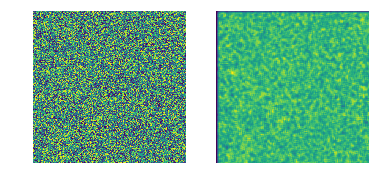

In [16]:
from matplotlib import pyplot as plt

Ictt = np.random.uniform(low=0, high=1.0, size=((250, 250))).astype(float)
Gctt = (np.ones((5, 5)) * (1/25)).astype(np.float)

%prun Hctt = naive_convolve_cython_with_ctypes_and_typing_ndarray(Ictt,Gctt)

plt.subplot(1, 2, 1)
plt.imshow(Ictt)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hctt)
plt.axis('off')

plt.show()